## Water level extraction from tidal models

In this script, we calculate tidal predictions for a site of interest using the FES2022 tidal model. Data is saved in the `Data/sitename/tide` folder. 
The model is available from the AVISO website and is described in these works:

> Carrere et al., OSTST 2022: A new barotropic tide model for global ocean: FES2022,
https://doi.org/10.24400/527896/a03-2022.3287

> Florent H. Lyard, Loren Carrere, Ergane Fouchet, Mathilde Cancet, David Greenberg, Gérald Dibarboure and Nicolas Picot: “FES2022 a step towards a SWOT-compliant tidal correction”, to be submitted to Ocean Sciences.

The FES2022 model can be downloaded (upon registration) from the [Aviso+ website](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes.html) and should be placed in the `FES2022` folder, within the project folder.  

First, we import the libraries needed for the prediction

In [1]:
from astropy.time import Time, TimeDelta
import pandas as pd
import datetime
import pyTMD
import pyTMD.io
import pyTMD.time
import pyTMD.predict
import pyTMD.tools
import pyTMD.utilities
import os
import numpy as np
import timescale.time
import datetime
import pytz
import matplotlib.pyplot as plt

A number of inputs is required to run the code. First, select the point where data should be extracted on an interactive map

In [2]:
from ipyleaflet import Map, Marker, Output

# Create a map centered at a default location
m = Map(center=(0, 0), zoom=2)

# Output widget to display selected coordinates and bounds
output = Output()

# Variables to store latitude, longitude, and map bounds
LAT, LON = None, None
map_bounds = []

# Function to handle double-click events
def handle_double_click(**kwargs):
    global LAT, LON, map_bounds
    with output:
        output.clear_output()
        # Check if the event is a double-click and contains coordinates
        if kwargs.get("type") == "dblclick" and "coordinates" in kwargs:
            coords = kwargs["coordinates"]
            LAT, LON = coords[0], coords[1]  # Save latitude and longitude
            # Clear existing markers
            m.layers = m.layers[:1]  # Keep only the base map
            # Add a new marker at the double-clicked coordinates
            marker = Marker(location=coords)
            m.add_layer(marker)
            print(f"Coordinates saved: Latitude={LAT}, Longitude={LON}")

        # Save the current map bounds
        map_bounds = m.bounds
        print(f"Map bounds updated: {map_bounds}")

# Add the double-click handler for saving coordinates and bounds
m.on_interaction(handle_double_click)

# Display the map and output
display(m, output)

# Function to get and display the saved variables
def show_saved_variables():
    global LAT, LON
    print(f"Saved Latitude: {LAT}")
    print(f"Saved Longitude: {LON}")
    return LAT, LON

# Function to get the map bounds
def get_map_bounds():
    global map_bounds
    if map_bounds:
        extent = {
            "southwest": {"lat": map_bounds[0][0], "lon": map_bounds[0][1]},
            "northeast": {"lat": map_bounds[1][0], "lon": map_bounds[1][1]},
        }
        print(f"Current Map Bounds: {extent}")
        return extent
    else:
        print("Map bounds have not been recorded. Please interact with the map.")
        return None

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Output()

Then, define the name of the model (default is FES2022), and the sitename

In [3]:
# name of the site
sitename = 'Lido' #Please use underscore instead of space

# insert the version of FES you are using (default is FES2022)
MODEL_NAME='FES2022'

# Insert the folder where the data is located and the coordinates at which you want to extrapolate the tidal data
folder='TidalModel/FES2022/'

# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'Data')

# create folder to save outputs from tidal data
folder_tides = os.path.join(filepath,sitename,'water_levels')
if not os.path.exists(folder_tides):
    os.makedirs(folder_tides)

Define the start and end date for the tidal prediction and the interval for the water levels. Default is 10 minutes.
Times should be defined as `yyyy,mm,dd,hh,mm,ss`. We suggest to leave hours, minutes and seconds to 00 as default.

In [4]:
# Define start and end date
start_date = datetime.datetime(2000, 1, 1, 00, 00, 00, tzinfo=pytz.UTC)
end_date = datetime.datetime(2024, 10, 31, 00, 00, 00, tzinfo=pytz.UTC)

# Time interval for water level extraction
interval_tide = 10 #minutes

Then, water levels are calculated. This cell takes a long time to run, depending on the time reported above.

In [5]:
current_path = os.getcwd()
full_path = os.path.join(current_path, folder)
model = pyTMD.io.model(full_path,format='netcdf',compressed=False).elevation(MODEL_NAME)

# Calculate the total number of 10-minute intervals between start and end dates
total_minutes = int((end_date - start_date).total_seconds() // 60)
interval_minutes = interval_tide
minutes = np.arange(0, total_minutes + interval_minutes, interval_minutes)

# Set the base date YMD to the start date
YMD = start_date.date()  # Using only the date part
# convert time from MJD to days relative to Jan 1, 1992 (48622 MJD)
ts = timescale.time.Timescale().from_calendar(YMD.year, YMD.month,
    YMD.day, minute=minutes)
hours = minutes/60.0

# delta time (TT - UT1) file
delta_file = pyTMD.utilities.get_data_path(['data','merged_deltat.data'])

constituents = pyTMD.io.FES.read_constants(model.model_file,
                                           type=model.type, version=model.version,
                                           compressed=model.compressed)
c = model.constituents
# delta time (TT - UT1)
DELTAT = ts.tt_ut1

amp,ph = pyTMD.io.FES.interpolate_constants(np.atleast_1d(LON), np.atleast_1d(LAT),
                                            constituents, scale=model.scale,
                                            method='spline', extrapolate=True)

# calculate complex phase in radians for Euler's
cph = -1j*ph*np.pi/180.0
# calculate constituent oscillation
hc = amp*np.exp(cph)
# predict tidal elevations at time and infer minor corrections
TIDE = pyTMD.predict.time_series(ts.tide, hc, c,
                                 deltat=DELTAT, corrections=model.corrections)
MINOR = pyTMD.predict.infer_minor(ts.tide, hc, c,
                                  deltat=DELTAT, corrections=model.corrections)
TIDE.data[:] += MINOR.data[:]

# Convert `ts` to a readable datetime format if it's not already
base_mjd = Time(YMD.isoformat(), format='iso', scale='utc').mjd  # MJD 
# Add minutes to your base MJD, converting minutes to days
mjd_times = base_mjd + (minutes / (24 * 60))  # Convert minutes to days
# Convert MJD to datetime for plotting
calendar_dates = Time(mjd_times, format='mjd', scale='utc').to_datetime()

# Create a DataFrame with the time and tide data
tides_df = pd.DataFrame({
    'DateTime': calendar_dates,
    'Tide': TIDE.data
})

The data is then saved in a `csv` file. Together with the data, we save in another file the location and start - end date information. A datafile that can be used as input in the [NOAA tidal datum calculator](https://access.co-ops.nos.noaa.gov/datumcalc/CalculateDatums) is also created. 

In [6]:
tides_df = pd.DataFrame({'Calendar Date (UTC)': calendar_dates,'TIDE_data': TIDE.data})
# Format the date column
tides_df['dates'] = pd.to_datetime(tides_df['Calendar Date (UTC)']).dt.strftime('%Y-%m-%d %H:%M:%S.%f+00:00')
# Format the tide column to 3 decimal places
tides_df['tide'] = tides_df['TIDE_data'].round(3)
tides_df.drop(columns=['Calendar Date (UTC)','TIDE_data'],inplace=True)

csvname = os.path.join(folder_tides,'%s_tides'%MODEL_NAME+'_'+sitename+'.csv')
tides_df.to_csv(csvname, index=False)
print('Tide csv file saved in the water_levels folder')

#Save tides for NOAA tidal datum calculator
tides_NOAA = pd.DataFrame({'Calendar Date (UTC)': calendar_dates,'TIDE_data': TIDE.data})
# Format 'Calendar Date (UTC)' column
tides_NOAA['Calendar Date (UTC)'] = tides_NOAA['Calendar Date (UTC)'].dt.strftime('%m/%d/%Y %H:%M')
#Export CSV
csvname = os.path.join(folder_tides,'%s_tides_NOAA'%MODEL_NAME+'_'+sitename+'.csv')
tides_NOAA.to_csv(csvname, float_format='%.3f',index=False)
print('Tide csv file for NOAA tidal datum calculator saved in the water_levels folder')

#Save metadata (coordinates, start date, end date) to a CSV file.
metadata_df = pd.DataFrame({
    "LAT": [LAT],
    "LON": [LON],
    "START_DATE": [start_date.isoformat()],
    "END_DATE": [end_date.isoformat()]
    })
filepath = os.path.join(folder_tides, '%s_location_date'%MODEL_NAME+'_'+sitename+'.csv')
metadata_df.to_csv(filepath, index=False)
print(f"Metadata saved to {filepath}")

Tide csv file saved in the water_levels folder
Tide csv file for NOAA tidal datum calculator saved in the water_levels folder
Metadata saved to /Users/alessiorovere/Dropbox/Mac/Documents/GitHub/CoastSat.Venice/Data/Lido/water_levels/FES2022_location_date_Lido.csv


Then, a plot is made to show the tidal data

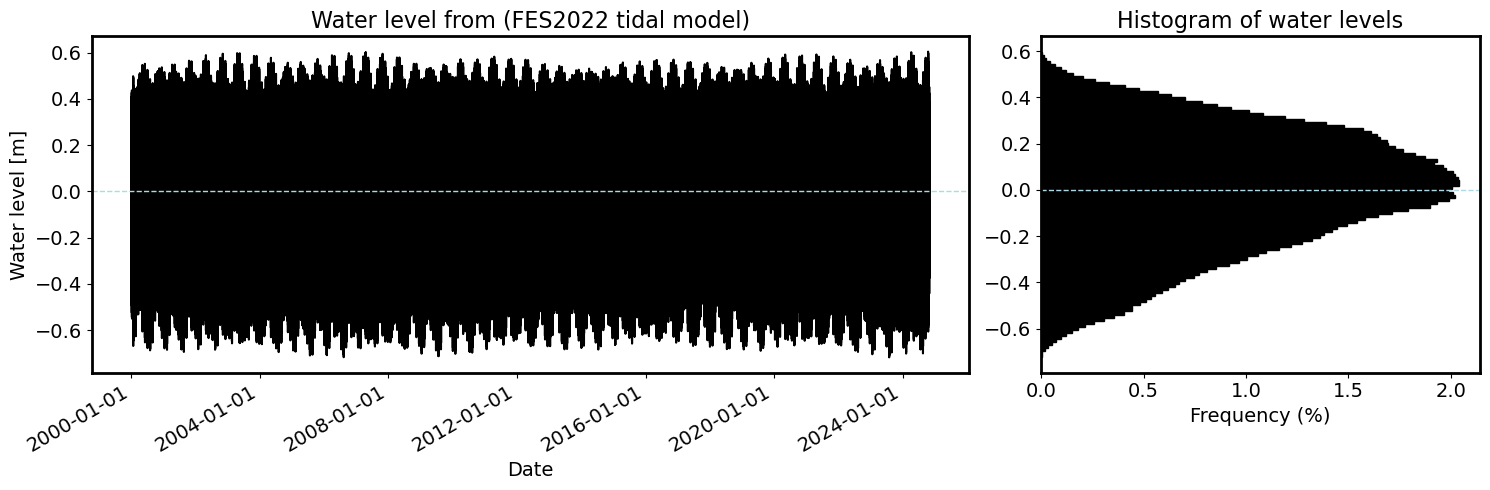

In [7]:
import matplotlib.dates as mdates

# Ensure the 'Calendar Date (UTC)' column is in datetime format
tides_NOAA['Calendar Date (UTC)'] = pd.to_datetime(tides_NOAA['Calendar Date (UTC)'])

fig_size = (15, 5)
fig, axs = plt.subplots(1, 2, figsize=fig_size, gridspec_kw={'width_ratios': [2, 1]})

# First plot: Time series
axs[0].plot(tides_NOAA['Calendar Date (UTC)'], tides_NOAA['TIDE_data'], color='black')
axs[0].set_xlabel('Date', fontsize=14)  # Increase font size for x-label
axs[0].set_ylabel('Water level [m]', fontsize=14)  # Increase font size for y-label
axs[0].set_title('Water level from ' + f'({MODEL_NAME} tidal model)', fontsize=16)  # Increase font size for title
# Increase font size of tick labels
axs[0].tick_params(axis='both', which='major', labelsize=14)
# Format the X-axis as a date axis
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Date format
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatic locator
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=30, ha="right")  # Rotate and align labels
axs[0].axhline(0, color='lightblue', linestyle='--', linewidth=1)  # Add line at Y=0

# Second plot: Histogram
# Convert frequencies to percentages
hist_data = tides_NOAA['TIDE_data']
counts, bins, patches = axs[1].hist(hist_data, bins=100, orientation='horizontal', color='black')
percentages = counts / counts.sum() * 100
# Clear the current histogram and re-plot with percentages
axs[1].cla()
axs[1].barh(bins[:-1], percentages, height=np.diff(bins), color='black', edgecolor='black')
axs[1].set_xlabel('Frequency (%)', fontsize=14)  # Set label for percentages
axs[1].set_title('Histogram of water levels', fontsize=16)  # Increase font size for title
axs[1].axhline(0, color='lightblue', linestyle='--', linewidth=1)  # Add line at Y=0
axs[1].tick_params(axis='both', which='major', labelsize=14)

# Adjust layout and save
plt.tight_layout()
fig.savefig(os.path.join(folder_tides, f'{sitename}_tide_timeseries.jpg'), dpi=300)
plt.show()

## Acknowledgments
This code uses the FES2022 Tide product, which was funded by CNES, produced by LEGOS, NOVELTIS and CLS and made freely available by AVISO. CNES, 2024. FES2022 (Finite Element Solution) Ocean Tide (Version 2022) [Data set]. CNES. https://doi.org/10.24400/527896/A01-2024.004

- Carrere et al., OSTST 2022: A new barotropic tide model for global ocean: FES2022,
https://doi.org/10.24400/527896/a03-2022.3287

- Florent H. Lyard, Loren Carrere, Ergane Fouchet, Mathilde Cancet, David Greenberg, Gérald Dibarboure and Nicolas Picot: “FES2022 a step towards a SWOT-compliant tidal correction”, to be submitted to Ocean Sciences.

FES22 data are used herein under the terms of the [license agreement](https://www.aviso.altimetry.fr/fileadmin/documents/data/License_Aviso.pdf)

This code was written in the framework of the WARMCOASTS project, led by A. Rovere at Ca' Foscari University of Venice. This software is part of a project that has received funding from the European Research Council (ERC) under the European Union’s Horizon 2020 research and innovation programme (Grant agreement No. ERC-StG-802414)
